# Principal Components Analysis
TL Mar 2019

In [1]:
%load_ext autoreload
%autoreload 2

from pipe import getdata
from pandas.tseries.offsets import BDay

from IPython.core.debugger import Tracer #pdb.set_trace()
import pdb

import statsmodels.tsa.stattools as ts

import random
import time
from itertools import compress
from sklearn.decomposition import PCA

Certain modules were not found which will affect which functions will work. Check if you have OneTick installed and module NumPy_OneTickQuery not found. Also check for win32com which might not work on Linux machines (untested)


Q:\wp\python-3.6.2.amd64\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
## Import data from csv files ##

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

def csv2df(csvName):
    
    # Import and format CSV as df
    # See spotEUR.csv for formatting template
    
    dfOut = pd.read_csv(csvName, parse_dates=[0],
                        infer_datetime_format=True, dayfirst=True)
    
    dfOut['Date'] = pd.to_datetime(dfOut['Date'])
    dfOut.set_index('Date', inplace=True)
    dfOut = dfOut.sort_index() # Sort chronologically
    
    return dfOut

In [3]:
## Stat analysis functions ##

def runStats(dfInput, nCol):
    
    dfRets = dfInput.diff()*100 # Daily returns in bps
    dfRets = dfRets.dropna() # First row is NaN, gets dropped, any others too
    
    colNames = dfRets.columns.get_values()
    colNames[nCol]
    
    retRange = dfRets[colNames[nCol]].max()-dfRets[colNames[nCol]].min()

    dfRets[colNames[nCol]].plot(kind='hist',bins=int(retRange),title=colNames[nCol])
    
    return print(colNames[nCol],"\n",
                 'range',retRange,"\n",
                 'mean',np.round(dfRets[colNames[nCol]].mean(),3),"\n",
                 'sigma',np.round(dfRets[colNames[nCol]].std(),3))

In [4]:
## PC Analysis (rolling window) ##

def pcaRun(dfPar):
    
    dfRets = dfPar.diff()*100 # Daily returns in bps
    dfRets = dfRets.dropna() # First row is NaN, gets dropped, any others too
    
    from scipy import stats
    dfRets_o = dfRets[(np.abs(stats.zscore(dfRets)) < 3).all(axis=1)] # Remove 3 sigma outliers
    
    cols = dfRets_o.shape[1]
    pca = PCA(n_components=cols)
    
    eigenVal = []
    eigenVec = []

    sampleSize = dfRets_o.shape[0]
    lookbackSize = 90
    
    for i in range(0,(sampleSize-lookbackSize)):
        #print(i,lookbackSize+i)
        pca.fit(dfRets_o.iloc[i:lookbackSize+i])
        eigenVal.append(pca.explained_variance_ratio_)
        eigenVec.append(pca.components_)
        
    dfPC1 = pd.DataFrame().reindex_like(dfRets_o)
    dfPC1 = dfPC1.iloc[lookbackSize:]
    
    for n in range(0,len(eigenVec)):
        for k in range(0,len(eigenVec[0][0])):
            dfPC1.iloc[n,k] = np.abs(eigenVec[n][0][k])
        
    return dfPC1

def pcaPlot(dfLoad, nDays, firstTenor=0, lastTenor='', mySize=(14,10)):
    
    if lastTenor=='':
        lastTenor = dfLoad.shape[1]
    
    return dfLoad.iloc[dfLoad.shape[0]-nDays:,
                       firstTenor:lastTenor].plot(legend=True,
                                                  figsize=mySize,
                                                  grid=True,
                                                  colormap='rainbow')

In [5]:
## Time series plotting functions ##

def curvePlot(dfInput, nDays, sLong, sShort, mySize=(14,5)):
    
    dfSpread = pd.DataFrame()
    dfSpread = (dfInput[sLong + ' Par Swap Rate']-dfInput[sShort + ' Par Swap Rate'])*100
    
    axSpread = dfSpread.iloc[dfSpread.shape[0]-nDays:].plot(legend=False,
                                                            figsize=mySize,
                                                            title='Curve '+sShort+'/'+sLong,
                                                            grid=True)
    return axSpread

def flyPlot(dfInput, nDays, wing1, belly, wing2, mySize=(14,5)):
    
    dfFly = pd.DataFrame()
    dfFly = ((2*dfInput[belly + ' Par Swap Rate'])
             -dfInput[wing1 + ' Par Swap Rate']
             -dfInput[wing2 + ' Par Swap Rate'])*100
    
    axFly = dfFly.iloc[dfSpread.shape[0]-nDays:].plot(legend=False,
                                                      figsize=mySize,
                                                      title='Fly '+wing1+'/'+belly+'/'+wing2,
                                                      grid=True)
    return axFly

In [6]:
## Column renaming function ##

def renameCol(dfInput,removeString=' Fwd Swap Rate'):
    
    test = dfInput.columns.get_values()
    
    for x in range(0,len(test)):
        test[x] = test[x].replace(removeString,'')
        
    dfInput.columns = test
    
    return dfInput

In [7]:
from sklearn.decomposition import PCA

def pcaRes(dfCross,trainSize,testSize):
    
    pca = PCA(n_components=3) #n_components=3
    
    m = trainSize # training set size
    n = testSize # test set size
    
    trainSet = dfCross.iloc[dfCross.shape[0]-n-m:dfCross.shape[0]-n] # Need a way to loop thru the entire sample
    testSet = dfCross.iloc[dfCross.shape[0]-n:]
    
    # Train model
    pca.fit(trainSet)

    # Regen rates from model both in and out of sample
    inSample = pca.transform(trainSet)
    outSample = pca.transform(testSet) #pd.DataFrame(pca.transform(testSet)).set_index(testSet.index)
    
    inRes = trainSet - pca.inverse_transform(inSample)
    outRes = testSet - pca.inverse_transform(outSample)
    
    return inRes, outRes

In [8]:
from sklearn.linear_model import LinearRegression

def costSlope(dfInput,plot=False):
    
    model = LinearRegression(fit_intercept=True)
    
    cols = dfInput.columns.get_values()
    x = np.arange(dfInput.shape[0])
    slope = []
    cost = []
    
    for i in range(0,dfInput.shape[1]):
        
        y = dfInput[cols[i]].values
        
        model.fit(x[:, np.newaxis], y)
        xfit = np.linspace(0, dfInput.shape[0], 1000)
        yfit = model.predict(xfit[:, np.newaxis])
        
        slope.append(model.coef_[0])
        cost.append(np.round(np.abs(model.coef_[0])-0.01,5))
               
        if plot==True:
            plt.scatter(x, y)
            plt.plot(xfit, yfit)
        
    return slope, cost

## PCA for XCCY curve 
Using time series of daily returns

In [37]:
# Data import
dfCross = renameCol(csv2df('eurusdFwdnew.csv'),' Basis Fwd Swap Spread')
dfCross = dfCross.dropna()
cols = dfCross.shape[1]

# Model setup
from sklearn.decomposition import PCA
pca = PCA(n_components=3) #n_components=3

n = 50 # test set size
m = 150 # training set size
trainSet = dfCross.iloc[dfCross.shape[0]-n-m:dfCross.shape[0]-n]
testSet = dfCross.iloc[dfCross.shape[0]-n:]

fullSet = dfCross.iloc[dfCross.shape[0]-n-m:]

# Train model
pca.fit(trainSet)

# Regen rates from model both in and out of sample
inSample = pca.transform(trainSet)
outSample = pca.transform(testSet) #pd.DataFrame(pca.transform(testSet)).set_index(testSet.index)

print(np.cumsum(pca.explained_variance_ratio_))

[ 0.83748001  0.94209006  0.96474127]


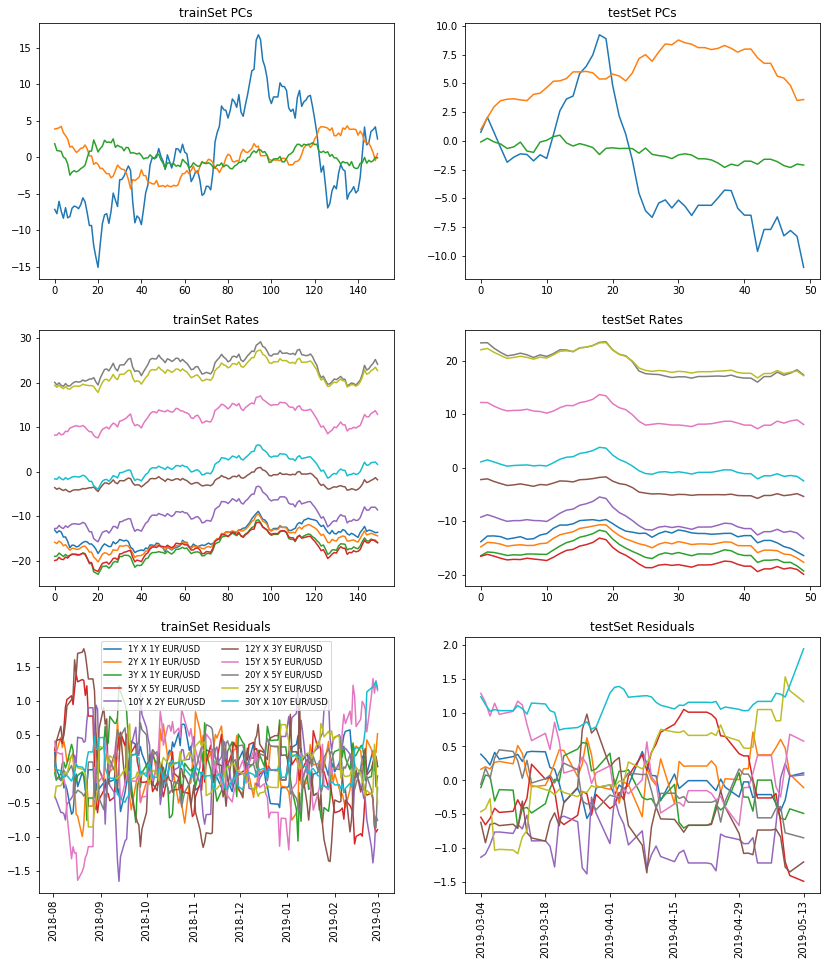

In [38]:
# Plotting results of above test

fig = plt.figure(figsize=(14,16)) #figsize=(12,10)
fig.add_axes()

ax1 = fig.add_subplot(321)
ax2 = fig.add_subplot(322)
ax3 = fig.add_subplot(323)
ax4 = fig.add_subplot(324)
ax5 = fig.add_subplot(325)
ax6 = fig.add_subplot(326)

ax1.plot(inSample)
ax1.set_title('trainSet PCs')
#ax1.tick_params(labelbottom=False)

ax2.plot(outSample)
ax2.set_title('testSet PCs')

ax3.plot(pca.inverse_transform(inSample))
ax3.set_title('trainSet Rates')

ax4.plot(pca.inverse_transform(outSample))
ax4.set_title('testSet Rates')

inRes = trainSet - pca.inverse_transform(inSample)
outRes = testSet - pca.inverse_transform(outSample)

ax5.plot(inRes)
ax5.set_title('trainSet Residuals') # Implement test for mean reversion
ax5.legend(inRes.columns.get_values(),loc='best',ncol=2,fontsize='small')
for tick in ax5.get_xticklabels():
    tick.set_rotation(90)

ax6.plot(outRes)
ax6.set_title('testSet Residuals')

for tick in ax6.get_xticklabels():
    tick.set_rotation(90)

plt.show()

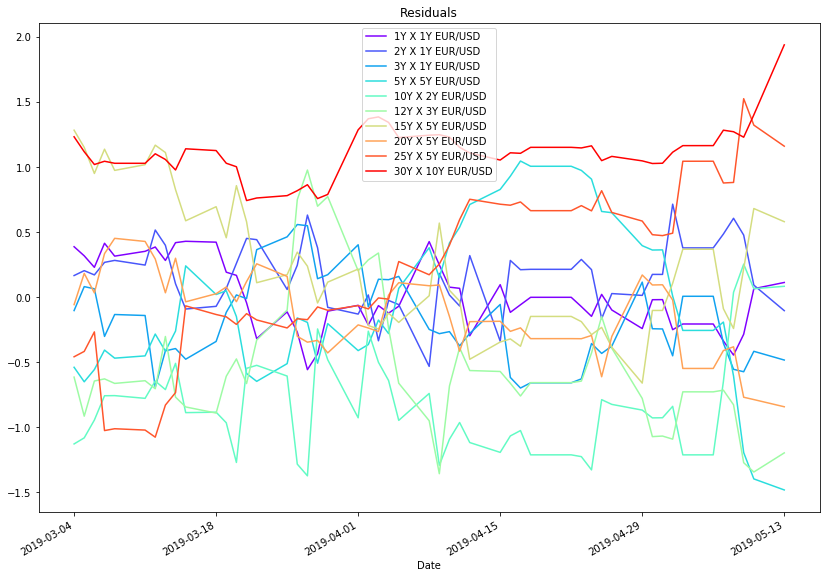

In [39]:
## Check out of sample residuals

reconOut = pca.inverse_transform(outSample)
resid = testSet - reconOut

resid.plot(legend=True,colormap='rainbow',figsize=(14,10),title='Residuals')
plt.show()

In [70]:
# PC analysis using yield levels not returns

dfRates = dfRename(csv2df('fwdEURsmall.csv'))
dfRates = dfRates.dropna()
cols = dfRates.shape[1]

n = 90
m = 300
trainSet = dfRates.iloc[dfRates.shape[0]-n-m:dfRates.shape[0]-n]
testSet = dfRates.iloc[dfRates.shape[0]-n:]

pca = PCA(n_components=3) #n_components=3

pca.fit(trainSet)
eigenValue = pca.explained_variance_ratio_ # How much variance in data is explained by PCs
eigenVectors = pca.components_
scoresFull = pca.fit_transform(trainSet)

pca.fit(trainSet)
outSample = pca.transform(testSet)

[ 0.7542681   0.17888248  0.0356389 ]


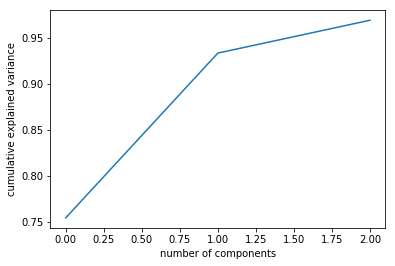

In [77]:
#import seaborn as sns; sns.set()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
print(pca.explained_variance_ratio_)
plt.show()

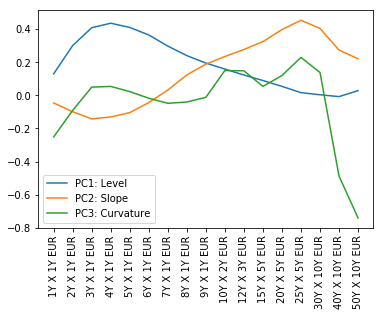

In [74]:
d = {'PC1: Level' : eigenVectors[0],
     'PC2: Slope' : eigenVectors[1],
     'PC3: Curvature' : eigenVectors[2]}

#header = dfRets.columns.get_values()

a = {'mats' : dfRates.columns.get_values()}
dfHead = pd.DataFrame(a)

df3PCs = pd.DataFrame(d)
ax = df3PCs.plot()
ax.set_xticks(df3PCs.index)
ax.set_xticklabels(dfHead.mats)
plt.xticks(rotation=90)
plt.show()

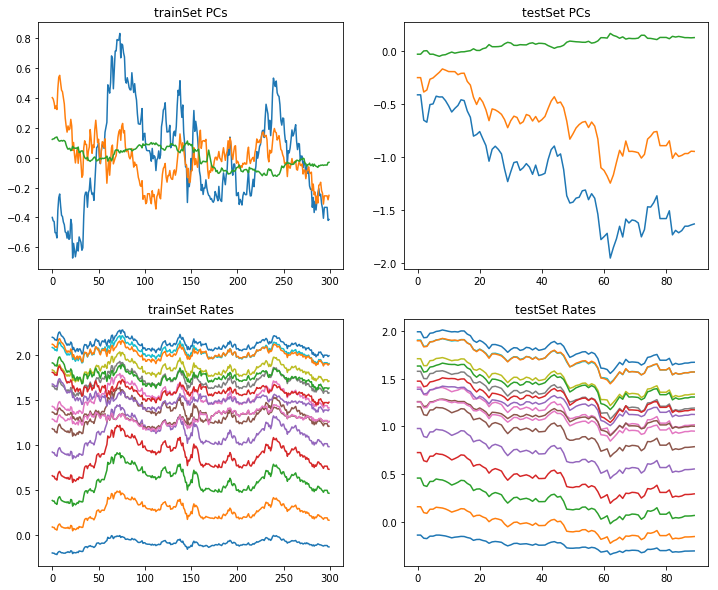

In [75]:
#Plotting results of above test

fig = plt.figure(figsize=(12,10)) #figsize=(12,10)
fig.add_axes()
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

ax1.plot(scoresFull)
ax1.set_title('trainSet PCs')
ax2.plot(outSample)
ax2.set_title('testSet PCs')
ax3.plot(pca.inverse_transform(scoresFull))
ax3.set_title('trainSet Rates')
ax4.plot(pca.inverse_transform(outSample))
ax4.set_title('testSet Rates')

plt.show()

In [ ]:
# Residuals
# Note: as we fit our model based on first and second moments (mean and variance), our the predictive power
# of our model decreases drastically when these underlying params shift ie an increase in volatility
# It may be interest to analyse which residuals retrace over time and which don't, the latter pointing
# to a structural shift

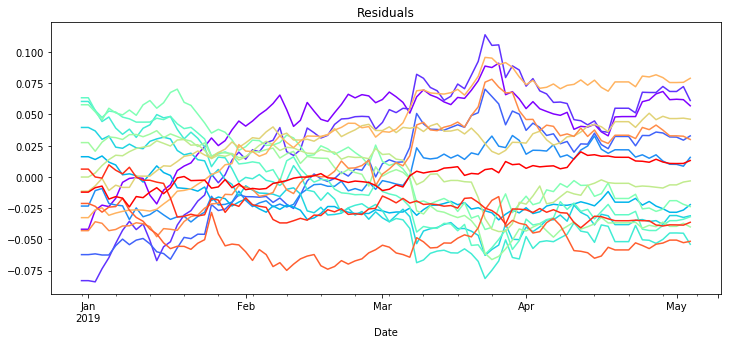

In [76]:
# Identify regime -> select model -> evaluate residuals

reconOut = pca.inverse_transform(outSample)
resid = testSet - reconOut

#resid.iloc[resid.shape[0]-3:].plot(kind='bar',grid=False,colormap='rainbow',legend=False,figsize=(12,3))
resid.plot(legend=False,colormap='rainbow',figsize=(12,5),title='Residuals')
plt.show()

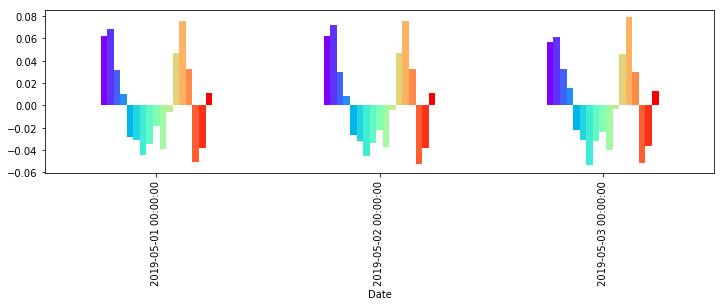

In [61]:
resid.iloc[resid.shape[0]-3:].plot(kind='bar',grid=False,colormap='rainbow',legend=False,figsize=(12,3))
plt.show()